In [1]:
from requests import get, post
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import sympy as sp
from matplotlib import pyplot as plt

# Carga de Dados
**Origem dos dados**

[Binance](https://www.binance.com)

[Documentação da API](https://github.com/binance/binance-spot-api-docs/blob/master/rest-api.md#klinecandlestick-data)

In [2]:
# Endpoints
url = 'https://api3.binance.com'
klines = url + '/api/v3/klines'
info = url + '/api/v3/exchangeInfo'

In [3]:
# Colunas
col = [
    'Open time','Open','High','Low','Close','Volume','Close time',
    'Quote asset volume','Number of trades','Taker buy base asset volume',
    'Taker buy quote asset volume','Ignore'
]

# Parametros
assets = ['btc', 'nano', 'bnb', 'waves', 'eos']
interval = '1d'
limit = 365
params = {}
def create_params(asset) -> dict:
    params[asset] = {
        "symbol": f"{asset.upper()}USDT",
        "interval": interval,
        "limit": limit
    }
    return params

for i in assets:
    create_params(i)

In [4]:
params

{'btc': {'symbol': 'BTCUSDT', 'interval': '1d', 'limit': 365},
 'nano': {'symbol': 'NANOUSDT', 'interval': '1d', 'limit': 365},
 'bnb': {'symbol': 'BNBUSDT', 'interval': '1d', 'limit': 365},
 'waves': {'symbol': 'WAVESUSDT', 'interval': '1d', 'limit': 365},
 'eos': {'symbol': 'EOSUSDT', 'interval': '1d', 'limit': 365}}

In [5]:
def clean(x):    
    # Obtendo dados
    asset = get(klines, params=params[x]).json()

    # Limpando - > deixando apenas as colunas: (close, time_close)
    asset = np.array(asset, dtype=float)[..., 4]
    
    return asset

#### Obtendo os preços dos ativos
- *map* aplica a função *clean* para cada *key* do dict *params*
- *np.array* transforma o map desepacotado **[*map]** em um array numpy (matriz)
- *pd.DataFrame* compila a transposta **array.T** da matriz isso em um dataframe pandas

In [6]:
df = pd.DataFrame(np.array([*map(clean, params.keys())]).T, columns=params.keys())
df

,btc,nano,bnb,waves,eos
0,6737.36,0.5057,13.1990,0.8917,2.3236
1,6359.11,0.4714,12.3354,0.8590,2.1928
2,6236.65,0.4658,12.1888,0.8144,2.1996
3,5881.42,0.4353,11.3008,0.7710,2.1133
4,6394.38,0.4600,12.1365,0.8262,2.2269
...,...,...,...,...,...
360,57351.56,5.0057,264.6513,9.9500,4.1536
361,54083.25,4.7621,254.7976,9.7854,4.0777
362,54340.89,4.8537,255.4646,11.1934,4.0899
363,52303.65,4.5016,248.5236,10.8360,3.6938


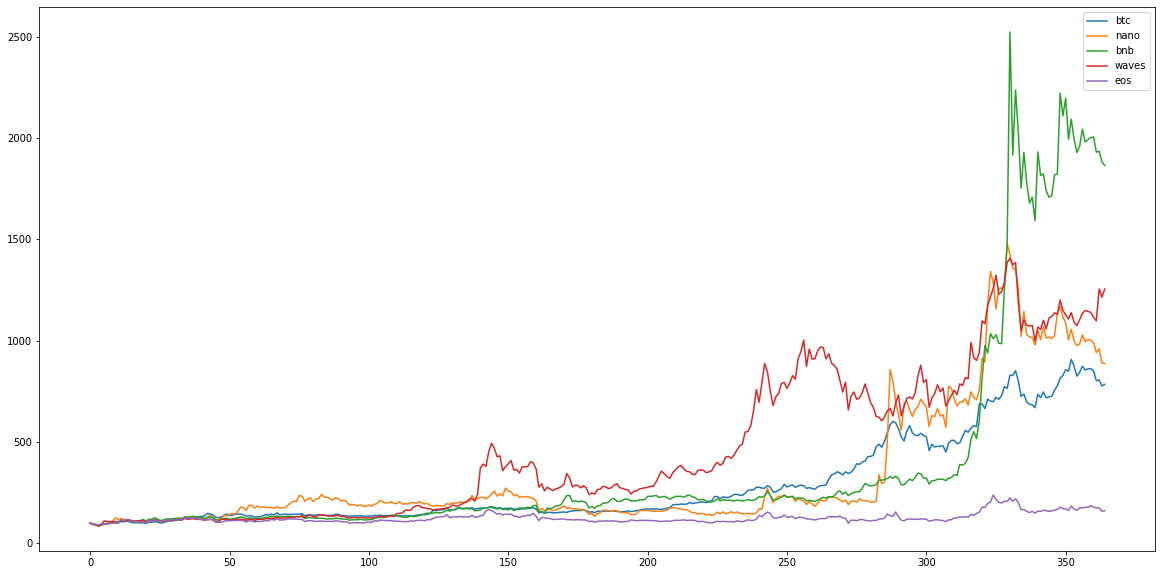

In [7]:
# Normaliza os dados na base 100
(df / df.iloc[0] * 100).plot(figsize=(20,10))
plt.show()

# Calculando Taxa de Retorno Simples, Logarítmicos e Volatilidade

**Retorno Simples:**
$$
r = \frac{P_i - P_f}{P_i} = \frac{P_f}{P_i} - 1
$$

**Retornos Logarítmicos**

$$
r = log(\frac{P_t}{P_{t-1}})
$$

In [8]:
def simple_return(asset):
    new_asset = (df[asset] / df[asset].shift(1)) - 1
    return new_asset

def log_return(asset):
    new_asset = (df[asset] / df[asset].shiftt(1)) - 1
    return new_asset

#### Aplicando o Retorno Simples nos  ativos
- *map* aplica a função *simple_return* para cada *column* do dataframe **df**
- *pd.DataFrame* compila a transposta **array.T** do map desepacotado **[*map]** em um dataframe **df**
- *iloc* fatia o **df** retirando a primeira linha **[1:,:]**

In [9]:
assets_returns = pd.DataFrame([*map(simple_return, df)]).T.iloc[1:,:]
assets_returns

,btc,nano,bnb,waves,eos
1,-0.056142,-0.067827,-0.065429,-0.036672,-0.056292
2,-0.019257,-0.011880,-0.011884,-0.051921,0.003101
3,-0.056958,-0.065479,-0.072854,-0.053291,-0.039234
4,0.087217,0.056742,0.073951,0.071595,0.053755
5,0.002512,0.020435,0.033667,0.198257,-0.008218
...,...,...,...,...,...
360,-0.012921,-0.012663,0.001320,-0.021382,-0.040251
361,-0.056987,-0.048665,-0.037233,-0.016543,-0.018273
362,0.004764,0.019235,0.002618,0.143888,0.002992
363,-0.037490,-0.072543,-0.027170,-0.031930,-0.096848


In [10]:
# Normalização entre 1 e -1
def norm(df):
    normalize = MaxAbsScaler().fit_transform(df)
    return normalize

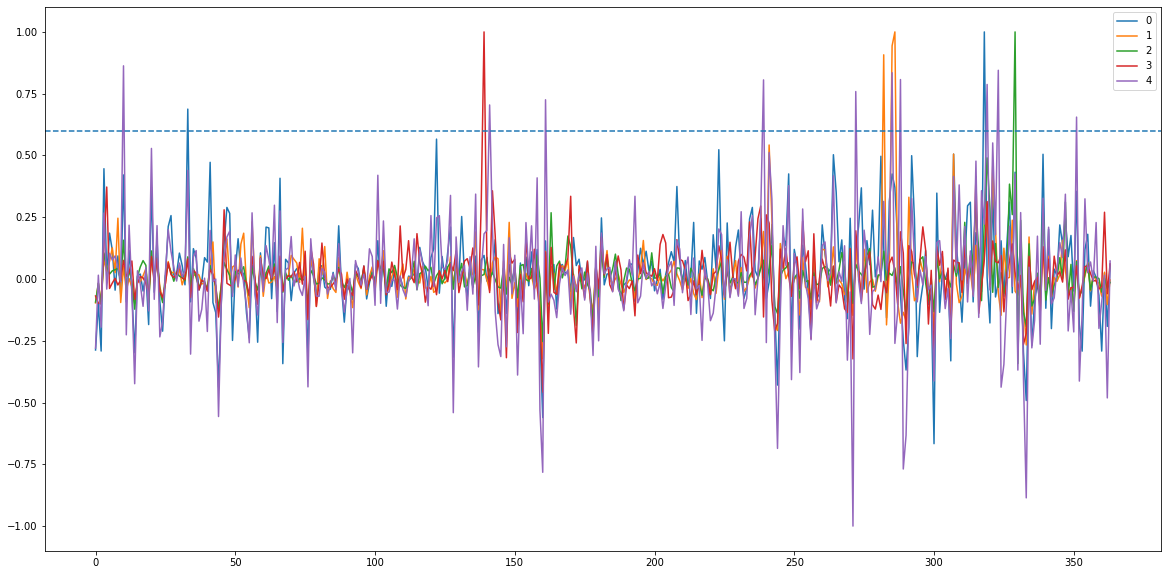

In [11]:
# Retornos diarios
pd.DataFrame(norm(assets_returns)).plot(figsize=(20,10))
plt.axhline(y=0.6, linestyle='--')
plt.show()

In [12]:
def mean_returns(asset):
    # media diaria
    x = assets_returns[asset].mean() * 100
    
    # media anual
    y = assets_returns[asset].mean() * 365 * 100
    
    # variacao diaria 
    z = assets_returns[asset].std() * 100

    # desvio padrao anual
    w = assets_returns[asset].std() * 365 ** 0.5 * 100
    return [x,y,z,w]

#### Aplicando o Retorno Simples nos  ativos
- *map* aplica a função *mean_returns* para cada *column* do dataframe **df**
- *pd.DataFrame* compila o map desempacotado **[*map]** em um dataframe **df**

In [13]:
col = ['Retorno Médio Diário', 'Retorno Médio Anual', 'Desvio Padrão Diário', 'Desvio Padrão Anual']
returns = pd.DataFrame(np.array([*map(mean_returns, assets_returns)]), index=assets_returns.columns,columns=col)
returns.style.format('{:.2f}%')

,Retorno Médio Diário,Retorno Médio Anual,Desvio Padrão Diário,Desvio Padrão Anual
btc,0.63%,230.77%,3.63%,69.27%
nano,0.94%,342.75%,8.96%,171.20%
bnb,1.00%,365.88%,6.67%,127.39%
waves,0.89%,326.22%,6.42%,122.64%
eos,0.25%,92.26%,4.94%,94.29%


# Calculando Taxa de Retorno de um Portifólio

**Retorno do Portifólio**

```
O retorno do portifólio é dado pelo somatório do produto
dos retornos pelo seu respectivo peso na carteira 
```

$$
r = \sum_{i=1}^{n} w_i\sigma_i
$$

In [14]:
# retornos anuais
annual_return = assets_returns.mean() * 365

In [15]:
# pesos de cada ativo na carteira
weights_A = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Somatório do produto vetorial
portifolio_return_A = np.dot(annual_return, weights_A) * 100
print("Portifólio A")
print(str(round(portifolio_return_A, 2)) + '%')

Portifólio A
271.57%


In [16]:
# pesos de cada ativo na carteira
weights_B = np.array([0.2, 0.2, 0.2, 0., 0.4])

# Somatório do produto vetorial
portifolio_return_B = np.dot(annual_return, weights_B) * 100
print("Portifólio B")
print(str(round(portifolio_return_B, 2)) + '%')

Portifólio B
224.78%


In [17]:
# pesos de cada ativo na carteira
weights_C = np.array([0.3, 0.1, 0.1, 0.3, 0.2])

# Somatório do produto vetorial
portifolio_return_C = np.dot(annual_return, weights_C) * 100
print("Portifólio C")
print(str(round(portifolio_return_C, 2)) + '%')

Portifólio C
256.41%


# Volatilidade

**Variância**

```
Mede a distância entre os valores e a média.
var(x) = média dos  quadrados - quadrado da média
```
$$
var(x) = \frac{1}{n}\sum_{i=1}^{n}(x_i - \bar{x})^2
$$

$$
= \frac{1}{n}\sum_{i=1}^{n}x_i² - \bar{x}²
$$

**Desvio Padrão**
```
Mede a variação média
dp(x) = raiz quadrada da variância
```
$$
\sigma(x) = \sqrt{var(x)}
$$

**Covariância**

```
Mede o grau de interdependência entre as variáveis
Cov(x,y) = média dos produtos - produto das médias
cov(x,y) >  0: x e y se movem na mesma direção
cov(x,y) <  0: x e y se movem em direções contrárias
cov(x,y) == 0: x e y são independentes
```
$$
cov(x, y) = \frac{1}{n}\sum_{i=1}^{n}(x_i - \bar{x})\cdot(y_i - \bar{y})
$$
$$
= \frac{1}{n}\sum_{i=1}^{n}x_i^2-\bar{x}^2
$$

**Coeficiente de Correlação**
```
Ajusta a cov(x,y) para um intervalo de [-1;1]
Corr(x,y) = {
        média dos produtos - produto das médias
        roduto das raiz quadrada da variância de x por y
}        
corr(x,y) = +ou- 1: o movimento de uma variável explica completamente o movimento da outra
corr(x,y) =  1: correlação positiva perfeita entre as duas variáveis.
corr(x,y) = -1: correlação negativa perfeita entre as duas variáveis.
corr(x,y) =  0: correlação nula
```

$$
corr(x,y) = \frac{cov(x,y)}{\sigma(x)\cdot \sigma(y)}
$$

**Covariância e Correlação**
$$
\begin{bmatrix}
var(x) && cov(x,y) \\
cov(x,y) && var(y)
\end{bmatrix}
$$

In [18]:
def variancia(asset):
    # variancia diaria
    x = assets_returns[asset].var() * 100
    
    # variancia anual
    y = assets_returns[asset].var() * 100*365

    return [x,y]

In [19]:
col = ['Variância Média Diário', 'Variância Média Anual']
assets_var = pd.DataFrame(np.array([*map(variancia, assets_returns)]), index=assets_returns.columns, columns=col)
assets_var.style.format('{:.5f}%')

,Variância Média Diário,Variância Média Anual
btc,0.13145%,47.97799%
nano,0.80297%,293.08237%
bnb,0.44460%,162.27801%
waves,0.41210%,150.41583%
eos,0.24356%,88.89828%


In [20]:
def g(df, col):
    # covariancia diaria
    cov = df[col].cov()
    
    # covariancia anual
    cov_Y = df[col].cov() * 250
    
    # correlacao
    corr = df[col].corr()

    return {
        'covariancia': cov,
        'covariancia_Y':cov_Y,
        'correlacao':corr
    }

In [21]:
cov_corr = g(df, ['btc_return', 'eth_return'])

KeyError: "None of [Index(['btc_return', 'eth_return'], dtype='object')] are in the [columns]"

In [ ]:
cov_corr['covariancia']

In [ ]:
cov_corr['covariancia_Y']

In [ ]:
cov_corr['correlacao']

# Risco de um Portifólio Simples (2 ativos)

$$
(w_1\sigma_1 + w_2\sigma_2)^2 => w_1 + w_2 = 1
$$